In [1]:
import re

import codecs
import numpy as np
import gensim

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

# Подготовьте данные для word2vec по одной из недавно прочитанных книг, удалив все символы, кроме букв и пробелов и обучите модель. Посмотрите результат.

In [2]:
with codecs.open('plut.txt', encoding='UTF8', mode='r') as f:    
    raw_docs = f.readlines()

docs = [re.sub(r'[^А-я ]', '', doc) for doc in raw_docs]

sentences = [sent for doc in docs for sent in doc.split('.')]
sentences = [[word for word in sent.lower().split()] for sent in sentences]
print(len(sentences), sentences[:200])

4642 [['прежде', 'чем', 'поведать', 'очень', 'кратко', 'о', 'судьбе', 'этого', 'человека', 'ученого', 'и', 'путешественника', 'хочется', 'отметить', 'что', 'ему', 'удалось', 'пройти', 'в', 'походах', 'на', 'коне', 'лодке', 'и', 'просто', 'пешком', 'расстояние', 'превышающее', 'окружность', 'земного', 'шара', 'подняться', 'на', 'тысячу', 'малых', 'и', 'больших', 'горных', 'вершин', 'одолеть', 'столько', 'же', 'перевалов', 'открыть', 'и', 'описать', 'сотни', 'месторождений', 'полезных', 'ископаемых', 'опровергнуть', 'десятки', 'устаревших', 'теорий', 'и', 'сделать', 'множество', 'открытий', 'для', 'того', 'чтобы', 'рассказать', 'обо', 'всем', 'этом', 'ему', 'потребовалось', 'написать', 'около', 'сорока', 'тысяч', 'страниц', 'убористым', 'почерком', 'то', 'есть', 'почти', 'семьдесят', 'восемьдесят', 'полноформатных', 'томов', 'знаменательно', 'что', 'эта', 'цифра', 'совпадает', 'с', 'окружностью', 'нашей', 'планеты', 'выраженной', 'в', 'километрах'], ['в', 'одном', 'из', 'писем', 'владими

In [3]:
word_model = gensim.models.Word2Vec(sentences, vector_size=100, min_count=1, window=5, epochs=100)

In [4]:
pretrained_weights = word_model.wv.vectors
vocab_size, embedding_size = pretrained_weights.shape
print(vocab_size, embedding_size)

28723 100


In [5]:
print('Похожие слова:')
for word in ['каштанов', 'громеко', 'золотого', 'расположились', 'туман', 'культурный']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

Похожие слова:
  каштанов -> громеко (0.74), макшеев (0.65), зоолог (0.65), папочкин (0.60), копоти (0.59), погруженный (0.55), налет (0.55), ботаник (0.54)
  громеко -> каштанов (0.74), макшеев (0.74), боровой (0.70), зоолог (0.68), папочкин (0.66), копоти (0.62), ботаник (0.60), налет (0.59)
  золотого -> убрав (0.74), рассекая (0.71), щупальца (0.67), усиливали (0.66), отдала (0.66), голую (0.66), поджатые (0.65), обогнула (0.64)
  расположились -> полукругом (0.64), амбары (0.56), сидели (0.53), расположившись (0.53), костров (0.52), уселась (0.51), лежали (0.50), растянувшись (0.50)
  туман -> низко (0.64), рассеялся (0.62), метель (0.61), солнце (0.60), ветер (0.58), грело (0.58), дождь (0.58), снег (0.58)
  культурный -> щекотанье (0.69), лежащая (0.62), тяжелую (0.61), бровями (0.57), фантазером (0.52), репутацию (0.51), жизнь (0.51), обратило (0.50)


# Из этого же текста (п.1) возьмите небольшой фрагмент, разбейте на предложения с одинаковым числом символов. Каждый символ предложения закодируйте с помощью one hot encoding. В итоге у вас должен получиться массив размера (n_sentences, sentence_len, encoding_size).

In [6]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [7]:
part_of_text = docs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


letters = list(np.array([chr(let) for let in range(ord('а'), ord('я')+1)] + [' '] + ['ё']).reshape(1, -1))
num_letters = len(letters[0])

max_sentence_len = 35
letters_to_look = 16

sentences = [sent.lower() for sents in part_of_text for sent in sents.split('.')]
sentences = ([np.array([letter for word in ' '.join(sent.split())[:max_sentence_len] for letter in word]) for sent in sentences])
sentences = np.array(list(filter(lambda x: len(x) == max_sentence_len, sentences)))

enc = OneHotEncoder(categories=letters)

encoded_sentences = np.empty((*sentences.shape, num_letters))

for i, sent in enumerate(sentences):
    encoded = enc.fit_transform(sent.reshape(-1, 1))
    enc_arr = encoded.toarray()
    encoded_sentences[i] = enc_arr

(4217, 35, 34)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0

In [8]:
class MyLinear(nn.Module):
    def __init__(self, inC, outC) -> None:
        super().__init__()
        self.dense = nn.Linear(inC, outC)
    def forward(self, x):
        return F.relu(self.dense(x))

class T9(nn.Module):
    def __init__(self, sentlen) -> None:
        super().__init__()
        self.lstm1 = nn.LSTM(34, sentlen, 2, batch_first=True)
        self.denses = nn.Sequential(
            MyLinear(sentlen, 34),
        )
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        x = self.denses(out)
        return x

In [9]:
data_len = encoded_sentences.shape[0]
data_tr = encoded_sentences

x_data = [data_tr[:, i:i+letters_to_look, :] for i in range(max_sentence_len-letters_to_look-1)]
y_data = [data_tr[:, i+1:i+letters_to_look+1, :] for i in range(max_sentence_len-letters_to_look-1)]

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)

tensor_x = torch.Tensor(x_data)
tensor_y = torch.Tensor(y_data)

T9_dataset = TensorDataset(tensor_x, tensor_y)
T9_dataloader = DataLoader(T9_dataset, batch_size=16)

model = T9(128)
opt = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

model.to(device)

T9(
  (lstm1): LSTM(34, 128, num_layers=2, batch_first=True)
  (denses): Sequential(
    (0): MyLinear(
      (dense): Linear(in_features=128, out_features=34, bias=True)
    )
  )
)

In [10]:
def train_step(loader, opti, criterion):
    model.train()
    running_loss = 0.
    
    for xs, ys in loader:
        xs = xs.to(device)
        ys = ys.to(device)

        opti.zero_grad()
        output = model(xs)
        loss = criterion(output, ys)
        loss.backward()
        opti.step()
        running_loss += loss

    with torch.no_grad():
        train_loss = running_loss / len(loader)
    return train_loss.item()

In [11]:
def idxToChar(ch):
    return letters[0][ch.item()]

def prepareInitData(d, encoder):
    sent = np.array(list(d)).reshape(-1, 1)
    x_tst = torch.Tensor(encoder.fit_transform(sent).toarray())
    x_tst = x_tst.reshape((1, *x_tst.shape))
    return x_tst.to(device)

def predictNextNLetters(model, encoder, inData, N : int):
    pred = inData
    x_tst = prepareInitData(inData, encoder)
    with torch.no_grad():
        for i in range(N):
            out = model(x_tst)
            a = out[-1].max(dim = 1, keepdim=True)[1]
            pred += idxToChar(a[-1])
            x_tst = prepareInitData(pred, encoder)
    return pred



In [13]:
NUM_EPOCHS = 250
for epoch in (pbar := tqdm(range(NUM_EPOCHS))):
    running_loss = train_step(T9_dataloader, opt, criterion)
    print(f"{epoch} example: ", predictNextNLetters(model, enc, " ", 32))
    pbar.set_description(f'[Epoch: {epoch + 1:2d}] loss: {running_loss:.3f}')

  0%|          | 0/250 [00:00<?, ?it/s]

0 example:   этой жиееннучинекувереневихиенее
1 example:   этой икинуевереуунеецеууучееенее
2 example:   котивнее ужегрю речце церцен ие 
3 example:   эктои оуеннецверненноговюцученец
4 example:   кроинтевуе ввеги в чевиву в ги в
5 example:   чкоетви уннунунугрнуцуну нууюнун
6 example:   кинтееруевогове ее ее ее в овеве
7 example:   ещично кручтутутву втургуют тутв
8 example:   чектоив вурнунунув нув нув ницу 
9 example:   ещункчит оврововоровововюрю чюрг
10 example:   неокруит в г в               ю  
11 example:   кинецовутрегч г гвг гв гог гв го
12 example:   инуерктовогото окою же отворо оч
13 example:   инкеу овтворггггрггггггггггггггг
14 example:   нкиеиту оврроворг в рог в юржуру
15 example:   коиетерувну гчегцц гяцяжю ццця т
16 example:   куниетт  о рог гоггггоггггвогого
17 example:   неукоитовтровтр втровтровтвггггг
18 example:   коитнутетеветевете рег грегегег 
19 example:   книуттиетете огровив ревив ворги
20 example:   уконетвиириииииии грюг юж и ги и
21 example:   кунииетет

In [14]:
# x_tst = torch.Tensor(data_tst[:, :12])
print(predictNextNLetters(model, enc, "а", 256))

анннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннннн


# Для обучения на нефтяных скважин добавьте во входные данные информацию со столбцов Gas, Water (т.е. размер x_data будет (440, 12, 3)) и обучите новую модель. Выход содержит Liquid, Gas и Water (для дальнейшего предсказания). Графики с результатами только для Liquid.

In [235]:
df = pd.read_csv('production.csv')


liquid = df.groupby('API')['Liquid'].apply(lambda df_: df_.reset_index(drop=True)).unstack()
gas = df.groupby('API')['Gas'].apply(lambda df_: df_.reset_index(drop=True)).unstack()
water = df.groupby('API')['Water'].apply(lambda df_: df_.reset_index(drop=True)).unstack()

In [236]:
def transform(d):
    _d = d.values
    _d = _d / _d.max()
    return _d[:, :, np.newaxis]

liquid = transform(liquid)
gas = transform(gas)
water = transform(water)

data = np.concatenate([liquid, gas, water], axis=2)

data_tr = data[:40]
data_tst = data[40:]

x_data = [data_tr[:, i:i+12] for i in range(11)]
y_data = [data_tr[:, i+1:i+13] for i in range(11)]

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)
print(x_data.shape, y_data.shape)

(440, 12, 3) (440, 12, 3)


In [237]:
tensor_x = torch.Tensor(x_data)
tensor_y = torch.Tensor(y_data)

oil_dataset = TensorDataset(tensor_x,tensor_y)
oil_dataloader = DataLoader(oil_dataset, batch_size=16)

In [238]:
class MyLinear(nn.Module):

    def __init__(self, inC, outC) -> None:
        super().__init__()
        self.dense = nn.Linear(inC, outC)
    def forward(self, x):
        return F.relu(self.dense(x))

class OilModel(nn.Module):
    def __init__(self, units=32):
        super().__init__()
        self.lstm1 = nn.LSTM(3, units, 2, batch_first=True)
        self.denses = nn.Sequential(
            MyLinear(units, units//2),
            MyLinear(units//2, 3),
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h, _ = self.lstm1(x)
        outs = []
        for i in range(h.shape[0]):
            outs.append(self.relu(self.denses(h[i])))
        out = torch.stack(outs, dim=0)
        return out

In [239]:
model = OilModel()
opt = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [240]:
NUM_EPOCHS = 20

for epoch in (pbar := tqdm(range(NUM_EPOCHS))):

    running_loss = 0.0
    num = 0
    for x_t, y_t in oil_dataloader:
        opt.zero_grad()

        outputs = model(x_t)
        loss = criterion(outputs, y_t)
        loss.backward()
        opt.step()

        running_loss += loss.item()
        num += 1
        
    pbar.set_description(f'[Epoch: {epoch + 1:2d}] loss: {running_loss / num:.3f}')

  0%|          | 0/20 [00:00<?, ?it/s]

In [241]:
x_tst = data_tst[:, :12]
predicts = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))

for i in range(12):
    x = np.concatenate((x_tst[:, i:], predicts), axis=1)
    x_t = torch.from_numpy(x).float()
    pred = model(x_t).detach().numpy()
    last_pred = pred[:, -1:]
    predicts = np.concatenate((predicts, last_pred), axis=1)

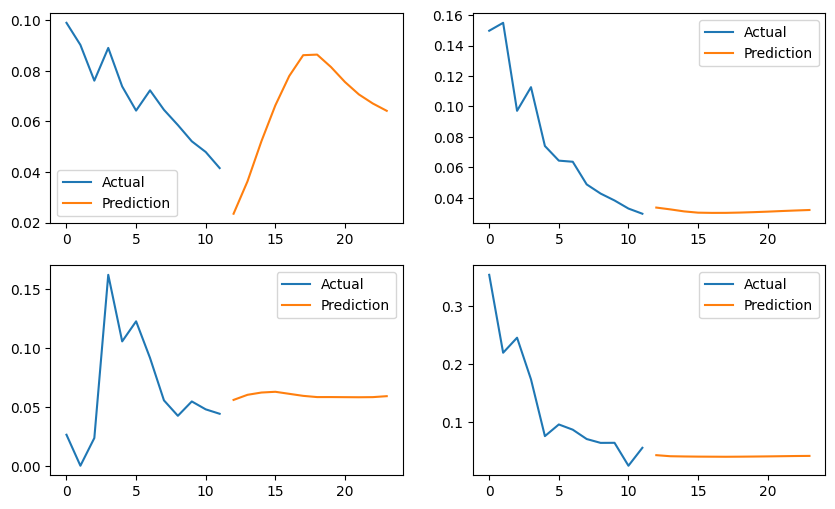

In [242]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for iapi in range(4):
    plt.subplot(2, 2, iapi+1)
    plt.plot(np.arange(x_tst.shape[1]), x_tst[iapi, :, 0], label='Actual')
    plt.plot(np.arange(predicts.shape[1])+x_tst.shape[1], predicts[iapi, :, 0], label='Prediction')
    plt.legend()
plt.show()